<a href="https://colab.research.google.com/github/kelvin17/AndrewNg-Deep-Learning/blob/master/Yanqing_Project_1_hotdog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [ ]:
import os
import time
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## todo check
from torchvision import transforms, datasets

We always check that we are running on a GPU

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [ ]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)} # result: {"hotdog:0, nonhotdog:1"}; enumerate(image_classes) result is (0,'hotdog'), (1,'nothotdog')
        self.image_paths = glob.glob(data_path + '/*/*.jpg') # result is a list containing all the image-path ".../train/hotdog/img1.jpg"

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]

        image = Image.open(image_path) # Image lib open the image
        c = os.path.split(os.path.split(image_path)[0])[1]
        # os.path.split 专门用来拆最后一个分隔符的。[0] 是最后一个分隔符前半段；[1]是后半段
        # image_path = ".../train/hotdog/img1.jpg"
        #     内部取前半段：                             os.path.split(image_path)[0] => .../train/hotdog
        #     外部取内部再次分隔的后半段：   os.path.split(os.path.split(image_path)[0])[1]  => hotdog

        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/hotdog_nothotdog/'
model_save_path = '/content/drive/MyDrive/model_output/hotdog_nothotdog/'


Mounted at /content/drive


In [ ]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
num_test_images = len(test_loader.dataset)
print(f'Test set has {num_test_images} images')

num_train_images = len(train_loader.dataset)
print(f'Train set has {num_train_images} images')

Test set has 1862 images
Train set has 2047 images


Let's look at some images from our data

In [ ]:
# images, labels = next(iter(train_loader))
# print(images.shape)
# print(labels.shape)

for images, labels in train_loader:
  print(type(images))
  print(images.dtype)
  print(images.shape)
  print(images.size())
  # print(images)
  print(type(labels))
  print(labels.dtype)
  print(labels.shape)
  print(labels.size())
  break

<class 'torch.Tensor'>
torch.float32
torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])
<class 'torch.Tensor'>
torch.int64
torch.Size([64])
torch.Size([64])


In [ ]:
# images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10)) # create a huge figure

for i in range(21):
    plt.subplot(5,7,i+1) # create 5row*7column subplot. the index of location is i+1
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1)) # swap axes : PyTorch.image [C,H,W] plt need [H,W,C]. so we need to do swap
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


# 1. function def

In [ ]:
## 1. calculate accuracy and loss
def evaluate(model, loader, device, loss_func):
  model.eval()
  running_loss = 0.0
  correct, total = 0,0
  with torch.no_grad():
    for imgs, labels in loader:
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      loss = loss_func(outputs, labels) # return 0-dim tensor; .item() will return a scale
      running_loss += loss.item() * imgs.size(0)
      pred = outputs.argmax(1)
      correct += (pred == labels).sum().item()
      total += labels.size(0)
  return 100 * correct / total, running_loss / total

## 3. show some figures of the result
def show_result(model, loader, classes, device):
  import matplotlib.pyplot as plt
  import numpy as np

  model.eval()

  data_iter = iter(loader)
  images, labels = next(data_iter)
  images, labels = images.to(device), labels.to(device)

  with torch.no_grad():
      outputs = model(images)
      probs = F.softmax(outputs, dim=1)
      _, pred = torch.max(outputs, 1)

  fig = plt.figure(figsize=(15, 5))

  for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    # because the image may be on GPU
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    pred_class = classes[pred[i]]
    true_class = classes[labels[i]]
    pred_prob = probs[i][pred[i]].item()*100

    color = 'green' if pred_class == true_class else 'red'

    ax.set_title(f"Predicted: {pred_class}\nActual: {true_class}\n prob: {pred_prob:.1f}%", fontsize=10, color=color)
    ax.axis('off')

  plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode="min", path="checkpoint.pt"):
        """
        patience: how many epoch the metric no improved will stop
        delta: the mini improved threadhold
        mode: min or max - min: the lower the better, e.g the loss; max: the higher the better, e.g the accuracy or the AUC
        path: where to save the model
        """
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, metric, model):
        score = -metric if self.mode == "min" else metric
        if self.best_score is None:
          self.best_score = score
          self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
          self.counter += 1
          if self.counter >= self.patience:
            self.early_stop = True
        else:
          self.best_score = score
          self.save_checkpoint(model)
          self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

# 2. Training


## 2.1 Small CNN
Performance - 80.5%

In [ ]:
## small CNN
class SmallCNN(nn.Module):
  def __init__(self):
    super(SmallCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # keep the size
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # keep the size
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # keep the size
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # keep the size
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(256 * 8 * 8, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 256 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# size = 128
batch_size = 64
epochs_num = 30

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

trainset = Hotdog_NotHotdog(train=True, transform=train_transform, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [ ]:
# training processing
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start = time.time()
for epoch in range(epochs_num):
  model.train() # train mode
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch [{epoch+1}/{epochs_num}], Loss:{running_loss/len(train_loader):.4}")

end_time = time.time()
test_acc, _ = evaluate(model, test_loader, device, criterion)
print(f"Time elapsed: {end_time - start:.2f} seconds, Test Accuracy: {test_acc:.2f}%")

Epoch [1/30, Loss:0.6991
Epoch [2/30, Loss:0.6428
Epoch [3/30, Loss:0.5642
Epoch [4/30, Loss:0.5435
Epoch [5/30, Loss:0.524
Epoch [6/30, Loss:0.5234
Epoch [7/30, Loss:0.5268
Epoch [8/30, Loss:0.5116
Epoch [9/30, Loss:0.4985
Epoch [10/30, Loss:0.4789
Epoch [11/30, Loss:0.4653
Epoch [12/30, Loss:0.4717
Epoch [13/30, Loss:0.4617
Epoch [14/30, Loss:0.4638
Epoch [15/30, Loss:0.4468
Epoch [16/30, Loss:0.4523
Epoch [17/30, Loss:0.4383
Epoch [18/30, Loss:0.4214
Epoch [19/30, Loss:0.4084
Epoch [20/30, Loss:0.3932
Epoch [21/30, Loss:0.4193
Epoch [22/30, Loss:0.4283
Epoch [23/30, Loss:0.4061
Epoch [24/30, Loss:0.4079
Epoch [25/30, Loss:0.4076
Epoch [26/30, Loss:0.4054
Epoch [27/30, Loss:0.388
Epoch [28/30, Loss:0.3832
Epoch [29/30, Loss:0.3936
Epoch [30/30, Loss:0.3714
Time elapsed: 389.41 seconds, Test Accuracy: 79.32%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


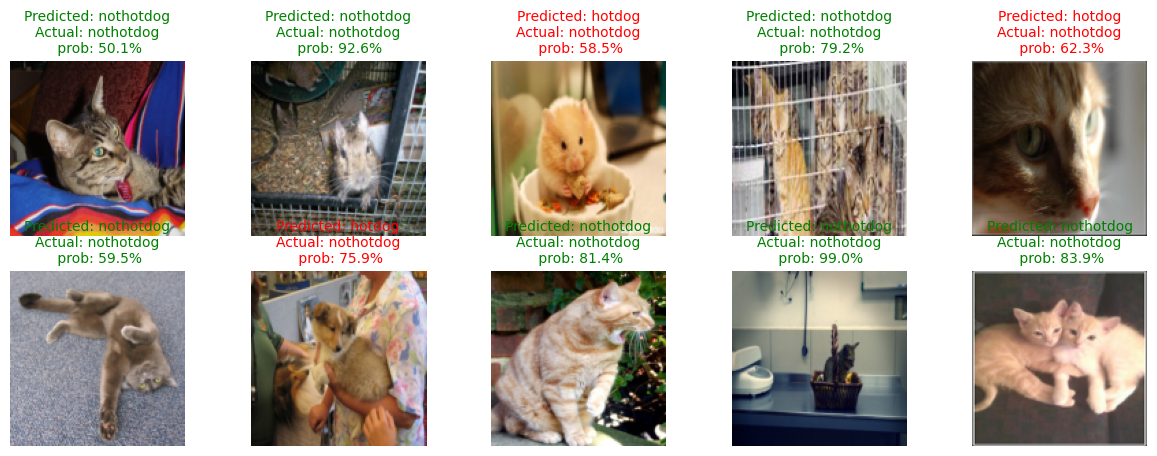

In [ ]:
# get some result samples
classes = list(testset.name_to_label.keys())
show_result(model, test_loader, classes, device)

## 2.2 Improved Small CNN
Performance - 81.63%
1. Improved Model layer
  - using batch normalization
  - using dropout
2. Data Augmentation
3. scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
## 2. Improved CNN model
batch_size = 64
epochs_num = 30

# -------------------------------
# imporved small CNN Definition
# -------------------------------
class ImprovedSmallCNN(nn.Module):
    def __init__(self):
        super(ImprovedSmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*8*8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# -------------------------------
# Augmentation and Normalize
# -------------------------------
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

trainset = Hotdog_NotHotdog(train=True, transform=transform_train, data_path=data_path)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=transform_test, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


# -------------------------------
# instantiate loss function, optimizer and learn rate scheduler
# -------------------------------
model = ImprovedSmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# -------------------------------
# training loop
# -------------------------------
best_acc = 0.0

for epoch in range(epochs_num):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

    # eval
    test_acc, test_loss = evaluate(model, test_loader, device, criterion)
    print(f"Epoch {epoch+1}/{epochs_num}, Loss: {running_loss/len(train_loader):.4f}, Test Acc: {test_acc:.2f}%, Test Loss={test_loss}")

    # save the best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), model_save_path+'/best_customed_model.pth')

print(f"Best Test Accuracy: {best_acc:.2f}%")

Epoch 1/30, Loss: 1.5511, Test Acc: 70.30%, Test Loss=0.599058522861831
Epoch 2/30, Loss: 0.5672, Test Acc: 73.85%, Test Loss=0.5348632974924258
Epoch 3/30, Loss: 0.5280, Test Acc: 74.22%, Test Loss=0.5293409930007926
Epoch 4/30, Loss: 0.5249, Test Acc: 65.74%, Test Loss=0.6387265729372791
Epoch 5/30, Loss: 0.5193, Test Acc: 74.38%, Test Loss=0.5500021032052701
Epoch 6/30, Loss: 0.4812, Test Acc: 73.36%, Test Loss=0.5816641608703277
Epoch 7/30, Loss: 0.4675, Test Acc: 77.01%, Test Loss=0.4922073959151861
Epoch 8/30, Loss: 0.4717, Test Acc: 77.55%, Test Loss=0.48388948345158717
Epoch 9/30, Loss: 0.4541, Test Acc: 77.39%, Test Loss=0.4849712149541181
Epoch 10/30, Loss: 0.4609, Test Acc: 78.89%, Test Loss=0.4670459555439995
Epoch 11/30, Loss: 0.4519, Test Acc: 74.87%, Test Loss=0.5476198055482321
Epoch 12/30, Loss: 0.4325, Test Acc: 77.60%, Test Loss=0.5044472872826774
Epoch 13/30, Loss: 0.4330, Test Acc: 74.81%, Test Loss=0.5308421164526975
Epoch 14/30, Loss: 0.4354, Test Acc: 76.85%, Te

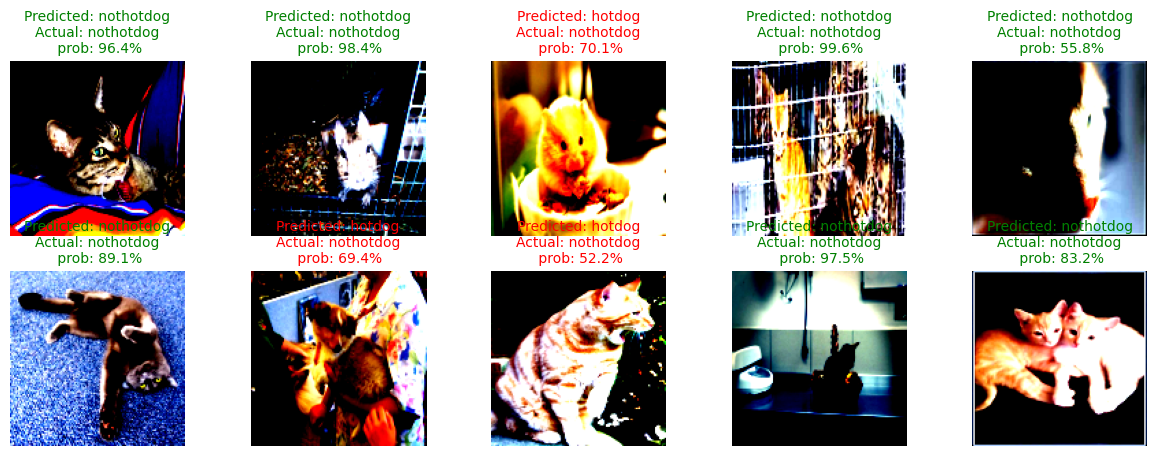

In [ ]:
classes = list(testset.name_to_label.keys())
show_result(model, test_loader, classes, device)

## 2.3 Transfer learning on resNet18
Performence - 92.64% on test
1. Fine tune resNet18(layer4+new fc for 2-classes)
2. Data Augmentation
3. scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
4. save the best test-accuracry parameters
5. loss and accuracy curve of training and testing

In [ ]:
epochs_num = 50
batch_size = 64
# -------------------------------
# 1. Load pre-trained model and setting fine tune
# -------------------------------
# 1.1 load pre-trained model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# model = models.resnet18(weights=None)

# 1.2 keep all the parameters except the last layer's
for param in model.parameters():
  param.requires_grad = False

# 1.3 replace the last fc layer for 2-classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2) # new 2-class fc ; default model.fc.requires_grad = True

# 1.4 set fine tune - layer4
for name, param in model.named_parameters():
    if name.startswith("layer4"):
        param.requires_grad = True

model = model.to(device)

# -------------------------------
# 2. Augmentation and Normalize
# -------------------------------
transform_train = transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
])

transform_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])


trainset = Hotdog_NotHotdog(train=True, transform=transform_train, data_path=data_path)
# train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

val_ratio = 0.2
total_size = len(trainset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

trainset, valset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=transform_test, data_path=data_path)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

# -------------------------------
# 3. Loss function & Optimizer for fine tune & learning scheduler
# -------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# -------------------------------
# 4. Train loop
# -------------------------------
best_test_acc = 0.0
train_losses, train_accs = [], []
test_losses, test_accs = [], []

model_path = model_save_path+'/best_resnet18_model-early-val.pth'
early_stopping = EarlyStopping(patience=10, mode="max", path=model_path)


for epoch in range(epochs_num):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  start = time.time()

  for imgs, labels in train_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    optimizer.zero_grad() # location: must be by followed by backward. recommand to the begining of every loop
    outputs = model(imgs)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * imgs.size(0)
    _, pred = outputs.max(1)
    correct += (pred == labels).sum().item()
    total += labels.size(0)

  train_loss = running_loss / len(trainset)
  train_acc = correct / total * 100
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  val_acc, val_loss = evaluate(model, val_loader, device, criterion)
  test_losses.append(val_loss)
  test_accs.append(val_acc)

  scheduler.step()

  elapsed = time.time() - start
  print(f"Epoch {epoch}/{epochs_num}, Train Loss: {train_loss:.4f},Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, train_acc: {train_acc:.2f}%, Time: {elapsed:.2f}s")

  early_stopping(val_acc, model)
  if early_stopping.early_stop:
    print("Early stopping")
    break

# 5. test_acc - reload the best model
best_model = models.resnet18()
num_ftrs = best_model.fc.in_features
best_model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming binary classification: Hot Dog or Not
best_model.load_state_dict(torch.load(model_path))
best_model.to(device)

test_acc, _ = evaluate(best_model, test_loader, device, criterion)
print(f"Test Accuracy: {test_acc:.2f}%, according model saved to {model_path}")

Epoch 0/50, Train Loss: 0.4954,Val Loss: 0.3766, Val Acc: 88.75%, train_acc: 82.05%, Time: 19.39s
Epoch 1/50, Train Loss: 0.2656,Val Loss: 0.2486, Val Acc: 90.71%, train_acc: 88.03%, Time: 15.43s
Epoch 2/50, Train Loss: 0.2031,Val Loss: 0.3211, Val Acc: 85.09%, train_acc: 91.70%, Time: 15.15s
Epoch 3/50, Train Loss: 0.1929,Val Loss: 0.2790, Val Acc: 89.73%, train_acc: 92.25%, Time: 13.40s
Epoch 4/50, Train Loss: 0.1927,Val Loss: 0.2267, Val Acc: 89.98%, train_acc: 91.76%, Time: 13.28s
Epoch 5/50, Train Loss: 0.1539,Val Loss: 0.2180, Val Acc: 91.93%, train_acc: 93.35%, Time: 13.48s
Epoch 6/50, Train Loss: 0.1275,Val Loss: 0.2253, Val Acc: 88.51%, train_acc: 95.12%, Time: 14.73s
Epoch 7/50, Train Loss: 0.1200,Val Loss: 0.2254, Val Acc: 91.20%, train_acc: 95.18%, Time: 13.49s
Epoch 8/50, Train Loss: 0.1174,Val Loss: 0.3163, Val Acc: 89.00%, train_acc: 95.12%, Time: 13.36s
Epoch 9/50, Train Loss: 0.1096,Val Loss: 0.2481, Val Acc: 92.67%, train_acc: 95.12%, Time: 13.14s
Epoch 10/50, Train L

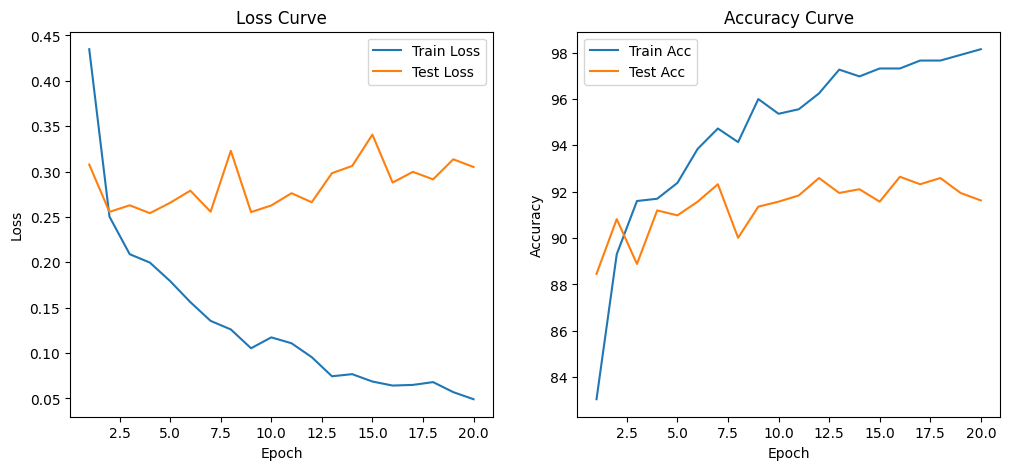

In [ ]:
# ===========================
# 5. Result analysis : plt loss and accuracy curve
# ===========================
def plot_curve(train_losses, train_accs, test_losses, test_accs):
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(range(1,epochs_num+1), train_losses, label='Train Loss')
  plt.plot(range(1,epochs_num+1), test_losses, label='Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Loss Curve')

  plt.subplot(1,2,2)
  plt.plot(range(1,epochs_num+1), train_accs, label='Train Acc')
  plt.plot(range(1,epochs_num+1), test_accs, label='Test Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy Curve')

  plt.show()

## plot resNet18 curve
plot_curve(train_losses, train_accs, test_losses, test_accs)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


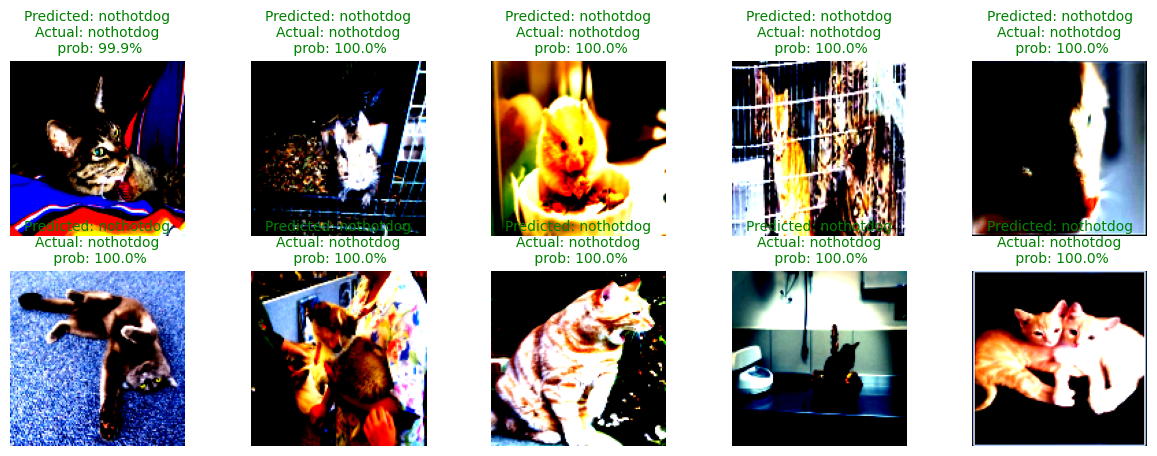

In [ ]:
classes = list(testset.name_to_label.keys())
show_result(model, test_loader, classes, device)

# saliency map analysis

In [ ]:
!pip install opencv-python

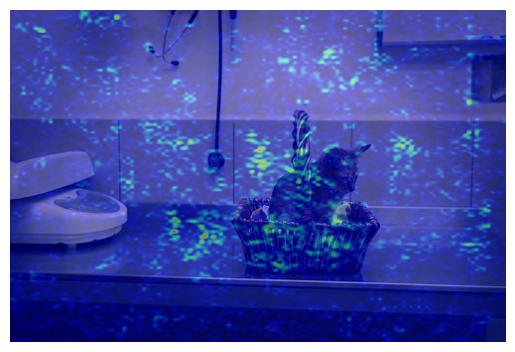

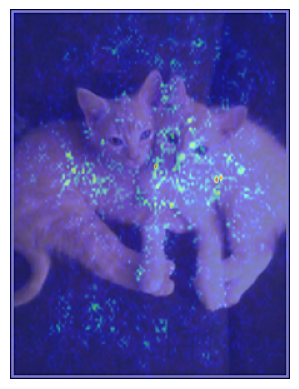

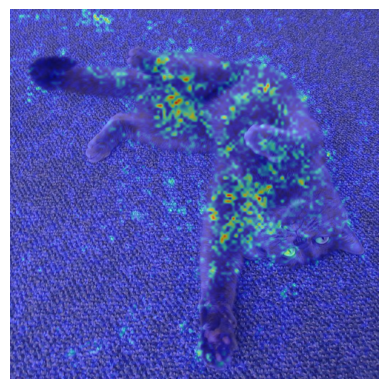

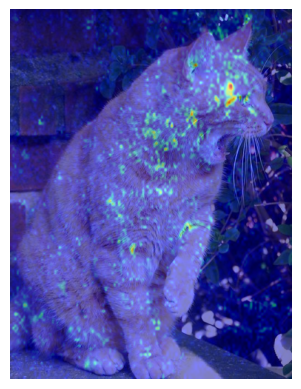

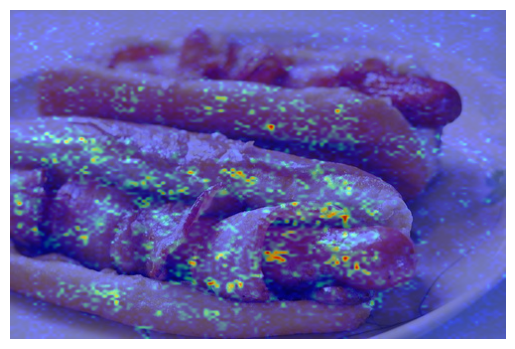

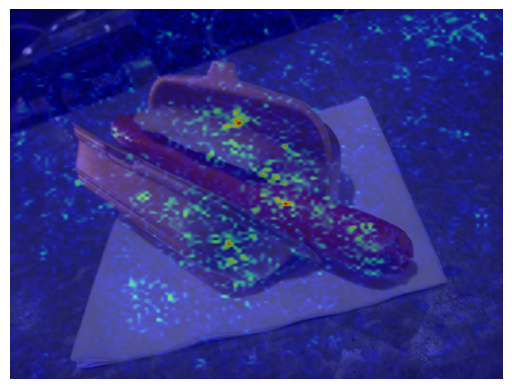

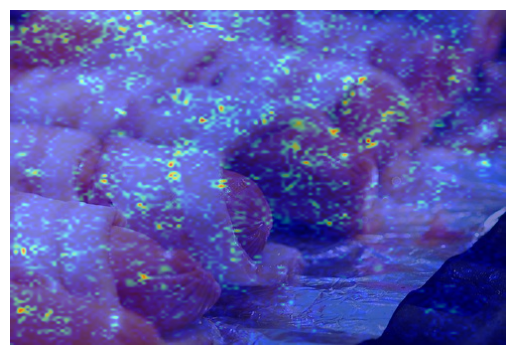

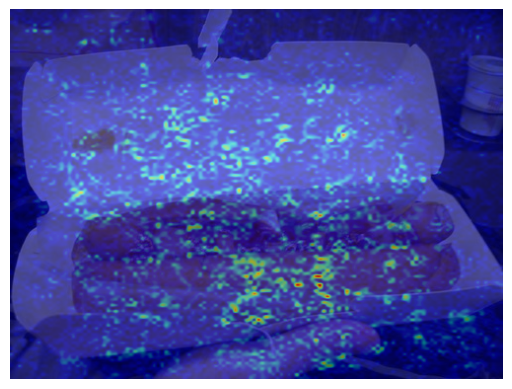

In [ ]:
# Load the fine-tuned ResNet-18 model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Assuming binary classification: Hot Dog or Not
model.load_state_dict(torch.load(model_path))
model.eval()


#  preprocess = test_transform
preprocess = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def get_saliency_map(img_path):
  img_pil = Image.open(img_path).convert("RGB")
  input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
  input_tensor.requires_grad_()

  # generate saliency map
  # Forward pass
  output = model(input_tensor)
  score = output[0, 1]  # Assuming the 'hot dog' class is index 1

  # Backward pass to get gradients
  model.zero_grad()
  score.backward()

  # Get the saliency map
  saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=1)
  saliency = saliency.squeeze().cpu().numpy()

  # Normalize the saliency map
  saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

  # Convert image to numpy array
  img = np.array(img_pil)

  # Resize saliency map to match image size
  saliency_resized = np.array(Image.fromarray(saliency).resize((img.shape[1], img.shape[0])))

  # Create an overlay
  overlay = np.uint8(plt.cm.jet(saliency_resized) * 255)
  overlay = overlay[..., :3]  # Remove alpha channel
  overlay = np.float32(overlay) / 255

  # Blend the original image and the saliency map
  blended = np.clip(overlay * 0.5 + np.float32(img) / 255 * 0.5, 0, 1)

  # Display the result
  plt.imshow(blended)
  plt.axis('off')
  plt.show()
  plt.close()
  torch.cuda.empty_cache()

img_paths = [
    data_path+"/test/nothotdog/"+"pets (683).jpg",
    data_path+"/test/nothotdog/"+"pets (682).jpg",
    data_path+"/test/nothotdog/"+"pets (679).jpg",
    data_path+"/test/nothotdog/"+"pets (677).jpg",
    data_path+"/test/hotdog/"+"hotdog (344).jpg",
    data_path+"/test/hotdog/"+"hotdog (343).jpg",
    data_path+"/test/hotdog/"+"hotdog (342).jpg",
    data_path+"/test/hotdog/"+"hotdog (341).jpg",
]

for img_path in img_paths:
  get_saliency_map(img_path)